In [1]:
import os 
import torch
torch.cuda.empty_cache()
torch.cuda.set_device(5)


In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import os
import json
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models # add models to the list
from sklearn.metrics import classification_report
from torch.utils.data import Dataset
from PIL import Image
import time
from tqdm import tqdm
import numpy as np
import random
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
PROJECT_ROOT = os.getcwd()

In [5]:
train_path = PROJECT_ROOT+'/train/'
validation_path = PROJECT_ROOT+ '/validation/'

In [6]:
from glob import glob
class SimCLRDataset(Dataset):
    def __init__(self, data_path, transform=None):
        
        self.samples = []
        self.label_map = {
            'no_tumor': 0,
            'tumor': 1
            }
        for label_name, label_value in self.label_map.items():
            folder_path = os.path.join(data_path, label_name)
            image_paths = glob(os.path.join(folder_path, '*'))

            for image_path in image_paths:
                self.samples.append((
                    image_path, label_value
                    ))   
            self.transform = transform
            
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        xi, xj = self.transform(image)
        return xi, xj
       
    

In [7]:
# transformation for SimCLR
from torchvision import transforms
class TwoCropTransform:
    def __init__(self,base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        return self.base_transform(x), self.base_transform(x)

simclr_transform = TwoCropTransform(transforms.Compose([
        transforms.RandomAffine(degrees=0, shear=5, scale=(0.95,1.05)),
        transforms.RandomRotation(3),      
        transforms.RandomHorizontalFlip(p=0.5),  # reverse 50% of images
        transforms.RandomVerticalFlip(p=0.3),  # reverse 30% of images
        transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]))

# SimCLR model
class SimCLR(nn.Module):
    def __init__(self, projection_dim=128):
        super().__init__()
        self.encoder = models.resnet18(weights=ResNet18_Weights.DEFAULT) 
        self.encoder.fc = nn.Identity()
        in_features = 512
        self.projector = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )
    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return z


In [8]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature = 0.3):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.cos_sim = nn.CosineSimilarity(dim=2)
        
    def forward(self, zis, zjs):
        batch_size = zis.size(0)
        reps = torch.cat([zis, zjs], dim=0)
        sim_matrix = self.cos_sim(reps.unsqueeze(1), reps.unsqueeze(0))
        
        labels = torch.cat([torch.arange(batch_size) for _ in range(2)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float().to(zis.device)

        mask = torch.eye(labels.shape[0],dtype=torch.bool).to(zis.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        sim_matrix = sim_matrix[~mask].view(sim_matrix.shape[0], -1)

        positives = sim_matrix[labels.bool()].view(labels.shape[0], -1)
        negatives = sim_matrix[~labels.bool()].view(sim_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0],dtype=torch.long).to(zis.device)
        return F.cross_entropy(logits / self.temperature, labels)

In [9]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
#entry point
def run_simclr_training(data_path, batch_size, epochs=100, patience=6, min_delta=1e-4):
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = SimCLRDataset(train_path, simclr_transform)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True, num_workers=4)

    model = SimCLR().to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay = 1e-5)
    criterion = NTXentLoss(temperature=0.3)
    scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor =0.5, patience=3, threshold=0.001)
    
    #scheduler = CosineAnnealingLR(optimizer, T_max =100, eta_min=1e-6)
# early stopping
    best_loss = float('inf')
    patience_counter = 0
    start_time = time.time()

    for epoch in range(epochs):
        total_loss = 0
        for xi, xj in dataloader:
            xi, xj = xi.to(device), xj.to(device)
            zi = model(xi)
            zj = model(xj)

            loss = criterion(zi, zj)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        print(f"SimCLR pretraining - Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

        if avg_loss < best_loss - min_delta:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        # stop training if patience limit is exceed
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. No improvement for {patience} epoches.")
            break
        #scheduler.step(avg_loss)
 
    torch.save(model.encoder.state_dict(), 'simclr_encoder.pth')
    duration = time.time() - start_time
    print(f'\nDuration: {duration:.0f} seconds') # Print time elapsed

    return model.encoder
   
# define the linear evaluation model
class LinearClassifier(nn.Module):
    def __init__(self, encoder, feature_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.classifier = nn.Linear(feature_dim, num_classes)
    def forward(self, x):
        with torch.no_grad():
            h = self.encoder(x)
        return self.classifier(h)


In [10]:
train_transform = transforms.Compose([
        transforms.RandomAffine(degrees=0, shear=5, scale=(0.95,1.05)),
        transforms.RandomRotation(3),      
        transforms.RandomHorizontalFlip(p=0.5),  # reverse 50% of images
        transforms.RandomVerticalFlip(p=0.3),  # reverse 30% of images
        transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])


valid_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])

In [11]:
class TumorDataset(Dataset):
    def __init__(self, data_path, transform=None):
        
        self.samples = []
        self.label_map = {
            'no_tumor': 0,
            'tumor': 1
            }
        for label_name, label_value in self.label_map.items():
            folder_path = os.path.join(data_path, label_name)
            image_paths = glob(os.path.join(folder_path, '*'))

            for image_path in image_paths:
                self.samples.append((
                    image_path, label_value
                    ))   
            self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [12]:
# SimCLR pretraining
encoder = run_simclr_training(
    data_path = train_path,
    batch_size=128,
    epochs=200,
    patience=6,
    min_delta=1e-4
    )


SimCLR pretraining - Epoch [1/200] Loss: 3.7058
SimCLR pretraining - Epoch [2/200] Loss: 3.0357
SimCLR pretraining - Epoch [3/200] Loss: 2.8591
SimCLR pretraining - Epoch [4/200] Loss: 2.7583
SimCLR pretraining - Epoch [5/200] Loss: 2.6879
SimCLR pretraining - Epoch [6/200] Loss: 2.6383
SimCLR pretraining - Epoch [7/200] Loss: 2.6070
SimCLR pretraining - Epoch [8/200] Loss: 2.5761
SimCLR pretraining - Epoch [9/200] Loss: 2.5563
SimCLR pretraining - Epoch [10/200] Loss: 2.5413
SimCLR pretraining - Epoch [11/200] Loss: 2.5275
SimCLR pretraining - Epoch [12/200] Loss: 2.5152
SimCLR pretraining - Epoch [13/200] Loss: 2.5053
SimCLR pretraining - Epoch [14/200] Loss: 2.4969
SimCLR pretraining - Epoch [15/200] Loss: 2.4878
SimCLR pretraining - Epoch [16/200] Loss: 2.4808
SimCLR pretraining - Epoch [17/200] Loss: 2.4731
SimCLR pretraining - Epoch [18/200] Loss: 2.4684
SimCLR pretraining - Epoch [19/200] Loss: 2.4654
SimCLR pretraining - Epoch [20/200] Loss: 2.4580
SimCLR pretraining - Epoch [2

In [13]:
encoder.eval()
encoder=encoder.to(device)

In [14]:
# Load datasets for linear evaluation
train_data = TumorDataset(
    data_path = train_path,
    transform=train_transform
)
valid_data = TumorDataset(
    data_path = validation_path,
    transform=valid_transform
)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)

In [15]:
# start to load pre-trained ResNet18 model and fine-tune
import os
import time
from tqdm import tqdm
import numpy as np
import random
import shutil

save_dir_simclr= os.path.join(PROJECT_ROOT, 'SimCLR')
os.makedirs(save_dir_simclr,exist_ok = True)
num_runs = 3
train_accuracies_all = []
valid_accuracies_all = []
train_losses_all = []
valid_losses_all = []

all_train_acc = []
all_val_acc =[]
all_train_loss = []
all_val_loss =[]
# track the best val loss of each run 
best_val_losses_all = []



for run in range(num_runs):
    print(f"\n===== Run {run+1} =====\n")
    torch.manual_seed(42 + run)
    torch.cuda.manual_seed(42 + run)
    np.random.seed(42 + run)
    random.seed(42 + run)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    train_loader = DataLoader(train_data, batch_size = 32, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size = 32, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder.eval()
    model = LinearClassifier(encoder, feature_dim=512, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor =0.5, patience=3, threshold=0.001)
    best_val_acc = 0
    best_model_path = os.path.join(save_dir_simclr, f"best_simclr_run{run+1 }.pth")
    
   

    # train the model with early stopping

    epochs = 50 # Keep the high epoch count, early stopping will decide when to stop
    patience =4 # Stop training if validation loss does not improve for 'patience' epochs
    min_delta = 0.001 # Minimum change to qualify as an improvement
    best_val_loss = float('inf') # Track best validation loss
    counter = 0 # Track consecutive epochs without improvement
    best_model_path = os.path.join(save_dir_simclr, f'best_simclr_run{run+1}.pth')

    train_losses = []
    valid_losses= []
    train_accuracies = []
    valid_accuracies= []

    # track best epoch metircs
    val_accuracy_at_best_loss = None
    train_accuracy_at_best_loss = None
    train_loss_at_best_loss = None
    val_loss_at_best_loss = None

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        train_correct = 0
        total_train = 0
    
    # Run the training batches
        for b, (X_train, y_train) in enumerate(train_loader):
            b+=1
            X_train, y_train = X_train.to('cuda'), y_train.to('cuda')
        
            # forward pass
            outputs = model(X_train)
            loss = criterion(outputs, y_train)

            # backward propagation 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # track loos and accuracy
            epoch_train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            train_correct += (preds == y_train).sum().item()
            total_train += y_train.size(0)

            # optional debug
            if b%20 == 0:
                print(f"Batch {b}, Loss: {loss.item():.4f}")

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_accuracy = train_correct / total_train

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # validation part
        model.eval()
        epoch_val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for X_val, y_val in valid_loader:
                X_val, y_val = X_val.to('cuda'), y_val.to('cuda')

                outputs = model(X_val)
                loss = criterion(outputs, y_val)

                epoch_val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_correct += (preds == y_val).sum().item()
                total_val += y_val.size(0)
       
           
        avg_val_loss = epoch_val_loss / len(valid_loader)
        val_accuracy = val_correct / total_val

        valid_losses.append(avg_val_loss)
        valid_accuracies.append(val_accuracy)

  

        print(f"Epoch: {epoch+1} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4g} | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        scheduler.step(avg_train_loss)
      
        
        # **Early stopping logic**
        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss # Update best loss
            val_accuracy_at_best_loss = val_accuracy
            train_accuracy_at_best_loss = train_accuracy
            train_loss_at_best_loss = avg_train_loss
            val_loss_at_best_loss = avg_val_loss

            counter = 0 # Reset counter
             # save the best model for this run
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at epoch {epoch+1}")
       
        else:
            counter += 1 # Increase counter
            if counter >= patience: # Stop if no improvement for 'patience' epochs
                print(f"Early stopping at epoch {epoch+1} (No improvement for {patience} epochs)")
                break
    #save metrics from each run
    all_train_acc.append(train_accuracy_at_best_loss)
    all_val_acc.append(val_accuracy_at_best_loss)
    all_train_loss.append(train_loss_at_best_loss)
    all_val_loss.append(val_loss_at_best_loss)   
    best_val_losses_all.append(best_val_loss)

    # save full per-epoch history
    train_accuracies_all.append(train_accuracies)
    valid_accuracies_all.append(valid_accuracies)
    train_losses_all.append(train_losses)
    valid_losses_all.append(valid_losses)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # Print time elapsed
# final results
print("\n===== Final Average Results ======\n")
print(f"Train Accuracy (best val loss): {np.mean(all_train_acc):.4f} +- {np.std(all_train_acc):.4f}")
print(f"Valid Accuracy: {np.mean(all_val_acc):.4f} +- {np.std(all_val_acc):.4f}")
print(f"Train Loss: {np.mean(all_train_loss):.4f} +- {np.std(all_train_loss):.4f}")
print(f"Valid Loss: {np.mean(all_val_loss):.4f} +- {np.std(all_val_loss):.4f}")

# save only the best model across runs
best_run_idx = np.argmin(best_val_losses_all)
best_model_path= os.path.join(save_dir_simclr, f"best_simclr_run{best_run_idx + 1}.pth")
final_best_model_path = os.path.join(save_dir_simclr, 'best_simclr_overall.pth')
shutil.copy(best_model_path, final_best_model_path)
print(f"n\Best overall model was from run {best_run_idx + 1} with val loss {best_val_losses_all[best_run_idx]:.4f}")
print(f"Saved as: {os.path.relpath(final_best_model_path)}")



===== Run 1 =====



Batch 20, Loss: 0.3746
Batch 40, Loss: 0.4677
Batch 60, Loss: 0.4513
Epoch: 1 - Train Loss: 0.4161, Train Acc: 0.8461 | Val Loss: 0.3506, Val Acc: 0.8791
Best model saved at epoch 1
Batch 20, Loss: 0.2441
Batch 40, Loss: 0.2794
Batch 60, Loss: 0.2609
Epoch: 2 - Train Loss: 0.3363, Train Acc: 0.8785 | Val Loss: 0.2988, Val Acc: 0.9023
Best model saved at epoch 2
Batch 20, Loss: 0.3339
Batch 40, Loss: 0.2532
Batch 60, Loss: 0.2458
Epoch: 3 - Train Loss: 0.2984, Train Acc: 0.8989 | Val Loss: 0.2784, Val Acc: 0.9302
Best model saved at epoch 3
Batch 20, Loss: 0.3001
Batch 40, Loss: 0.2140
Batch 60, Loss: 0.2675
Epoch: 4 - Train Loss: 0.2823, Train Acc: 0.9099 | Val Loss: 0.2547, Val Acc: 0.9326
Best model saved at epoch 4
Batch 20, Loss: 0.3147
Batch 40, Loss: 0.1950
Batch 60, Loss: 0.2226
Epoch: 5 - Train Loss: 0.2649, Train Acc: 0.9198 | Val Loss: 0.2476, Val Acc: 0.9349
Best model saved at epoch 5
Batch 20, Loss: 0.2530
Batch 40, Loss: 0.2199
Batch 60, Loss: 0.2532
Epoch: 6 - Train Loss

In [16]:
# save full simCLR model 
torch.save(encoder.state_dict(), os.path.join(save_dir_simclr, 'best_simclr_encoder_only.pth'))

In [17]:
model = LinearClassifier(encoder = encoder, feature_dim=512, num_classes=2).to(device)

In [18]:
model_dir = os.path.join(PROJECT_ROOT, 'SimCLR')
model_filename = 'best_simclr_overall.pth'
model_path = os.path.join(model_dir, model_filename)

In [19]:
model.load_state_dict(torch.load(model_path))
model  = model.to(device)
model.eval()

LinearClassifier(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [20]:
import seaborn as sns
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        _, preds = torch.max(outputs,1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [21]:
print("classification_report:\n")
print(classification_report(all_labels, all_preds))

classification_report:

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        59
           1       0.99      0.99      0.99       371

    accuracy                           0.98       430
   macro avg       0.98      0.95      0.96       430
weighted avg       0.98      0.98      0.98       430



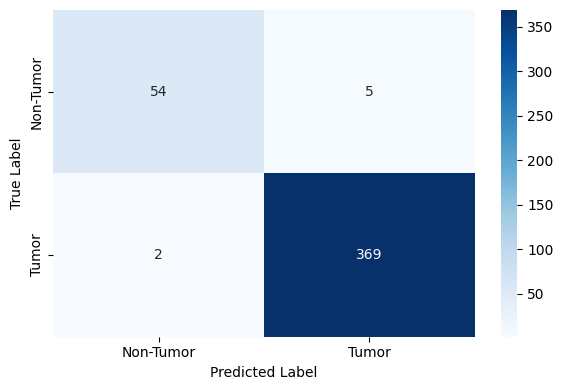

In [22]:
# confusion matrix
# visulize train and valid loss
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Tumor', 'Tumor'],
            yticklabels=['Non-Tumor','Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('')
plt.tight_layout()
plt.show()

In [23]:
max_len = max(len(run) for run in train_accuracies_all)

In [24]:
def pad_to_max(arr_list, max_len):
    return np.array([np.pad(run, (0, max_len - len(run)), constant_values=np.nan) for run in arr_list])

train_accuracies_pad = pad_to_max(train_accuracies_all, max_len)
valid_accuracies_pad = pad_to_max(valid_accuracies_all, max_len)
train_losses_pad = pad_to_max(train_losses_all, max_len)
valid_losses_pad = pad_to_max(valid_losses_all, max_len)

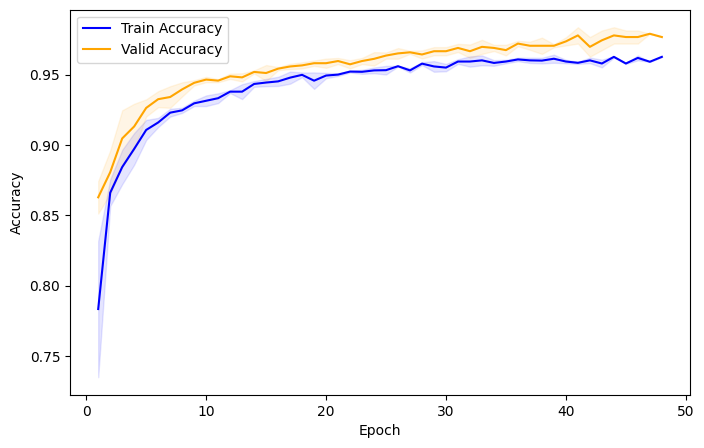

In [25]:
epochs = list(range(1, max_len + 1))
mean_train_acc = np.nanmean(train_accuracies_pad, axis=0)
std_train_acc = np.nanstd(train_accuracies_pad, axis=0)

mean_valid_acc = np.nanmean(valid_accuracies_pad, axis=0)
std_valid_acc = np.nanstd(valid_accuracies_pad, axis=0)


plt.figure(figsize = (8,5))
plt.plot(epochs, mean_train_acc, label='Train Accuracy', color = 'blue')
plt.fill_between(epochs, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, alpha = 0.1, color = 'blue')

plt.plot(epochs, mean_valid_acc, label='Valid Accuracy', color = 'orange')
plt.fill_between(epochs, mean_valid_acc - std_valid_acc, mean_valid_acc + std_valid_acc, alpha = 0.1, color = 'orange')

plt.title('')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
def pad_to_max(loss_list, max_len):
    return np.array([np.pad(run, (0, max_len - len(run)), constant_values=np.nan) for run in loss_list])


train_losses_pad = pad_to_max(train_losses_all, max_len)
valid_losses_pad = pad_to_max(valid_losses_all, max_len)

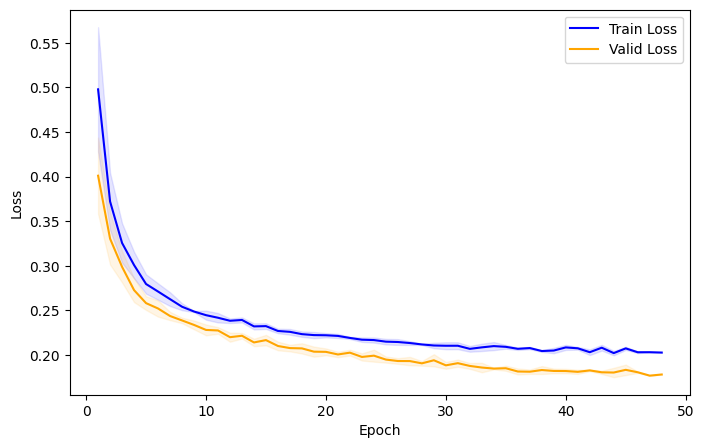

In [27]:
epochs = list(range(1, max_len + 1))
mean_train_loss = np.nanmean(train_losses_pad, axis=0)
std_train_loss = np.nanstd(train_losses_pad, axis=0)

mean_valid_loss = np.nanmean(valid_losses_pad, axis=0)
std_valid_loss = np.nanstd(valid_losses_pad,axis=0)

epochs = list(range(1, len(mean_train_loss)+1))

plt.figure(figsize = (8,5))
plt.plot(epochs, mean_train_loss, label='Train Loss', color = 'blue')
plt.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha = 0.1, color = 'blue')

plt.plot(epochs, mean_valid_loss, label='Valid Loss', color = 'orange')
plt.fill_between(epochs, mean_valid_loss - std_valid_loss, mean_valid_loss + std_valid_loss, alpha = 0.1, color = 'orange')

plt.title('')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()